### Preamble
Import relevant Python libraries, including Phosphoros plot utilities and NNPZ.

In [1]:
%matplotlib inline
import Euclid
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from astropy.table import Table, join, vstack
from astropy import units as u
from astropy.units import photometric
from IPython.display import set_matplotlib_formats

# Silence numpy warnings, since there are NaN around
np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
plt.rcParams['figure.figsize'] = (20, 10)
#set_matplotlib_formats('svg')

In [5]:
%elogin
%erun Phosphoros

In [6]:
from PhzCLI.PlotSpecZComparison import SpeczPhotozPlot, displayHistogram, compute_stats, boxPlot

# Input catalogs and NNPZ configuration

In [7]:
nnpz_config_path = '/home/aalvarez/Work/Data/DC2/nnpz_prior.conf'
nnpz_config = dict()
exec(open(nnpz_config_path, 'rt').read(), nnpz_config)

## NNPZ and validation

In [8]:
# All stats will be done with this point estimate
phz_column = 'REDSHIFT_MODE'
z_column = 'L15PHZ'

In [9]:
phz_catalog_path = '/home/aalvarez/Work/Data/DC2/uniform_notpruned.fits'
valid_path = '/home/aalvarez/Work/Data/DC2/valid_specz_phz_cat.fits'

In [10]:
phz_catalog = Table.read(phz_catalog_path, hdu=1)
pdz_bins = Table.read(phz_catalog_path, hdu=2)
valid_catalog = Table.read(valid_path, hdu=1)

In [11]:
phz_isnan = np.isnan(phz_catalog[phz_column])
if phz_isnan.any():
    print(f'Found {phz_isnan.sum()} records with a NaN PHZ! Removing them.')
    phz_catalog = phz_catalog[phz_isnan == False]

In [12]:
valid_catalog = valid_catalog[valid_catalog[z_column] >= 0]

In [13]:
phz_catalog = join(phz_catalog, valid_catalog, 'ID')

## Compute AB magnitudes
A cut is applied on VIS magnitude, but we compute for all bands here.

In [14]:
for flux in [flux for flux in phz_catalog.colnames if flux.startswith('FLUX_')]:
    band = '_'.join(flux.split('_')[1:])
    print(f'Computing MAG_AB_{band}')
    phz_catalog[f'MAG_AB_{band}'] = (phz_catalog[flux] * u.uJy).to(u.mag(photometric.AB))

Computing MAG_AB_G_1
Computing MAG_AB_G_2
Computing MAG_AB_G_3
Computing MAG_AB_R_1
Computing MAG_AB_R_2
Computing MAG_AB_R_3
Computing MAG_AB_I_1
Computing MAG_AB_I_2
Computing MAG_AB_I_3
Computing MAG_AB_VIS
Computing MAG_AB_Z_1
Computing MAG_AB_Z_2
Computing MAG_AB_Z_3
Computing MAG_AB_Y_1
Computing MAG_AB_Y_2
Computing MAG_AB_Y_3
Computing MAG_AB_J_1
Computing MAG_AB_J_2
Computing MAG_AB_J_3
Computing MAG_AB_H_1
Computing MAG_AB_H_2
Computing MAG_AB_H_3
Computing MAG_AB_RADIUS_DETECT


## Apply cuts
VIS SNR must be $\ge$ 10, and VIS magnitude cut between 17 and 24.

In [15]:
snr_vis_cut = (phz_catalog['FLUX_VIS'] / phz_catalog['FLUXERR_VIS'] >= 10)
mag_vis_cut = np.logical_and(phz_catalog['MAG_AB_VIS'] >= 17, phz_catalog['MAG_AB_VIS'] <= 24.5)

In [16]:
phz_cut_catalog = phz_catalog[np.logical_and(snr_vis_cut, mag_vis_cut)]
print(len(phz_cut_catalog))

53451


# Validate with true Z

In [17]:
data, mean, median, sigma, mad, outliersPercent,sigmaNoOutliers, meanNoOutliers = compute_stats(phz_cut_catalog[z_column], phz_cut_catalog[phz_column])

/home/aalvarez/miniconda3/envs/phz/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


--> Mean                :  0.11663374735154627
--> Median              :  0.02770068868994713
--> Sigma               :  0.37920297180998347
--> Mad                 :  0.08293643593788147
--> Outliers            :  34.081682288451105 %
--> Sigma (no outliers) :  0.039461166


Text(0.5, 0.98, 'PhotoZ vs SpecZ')

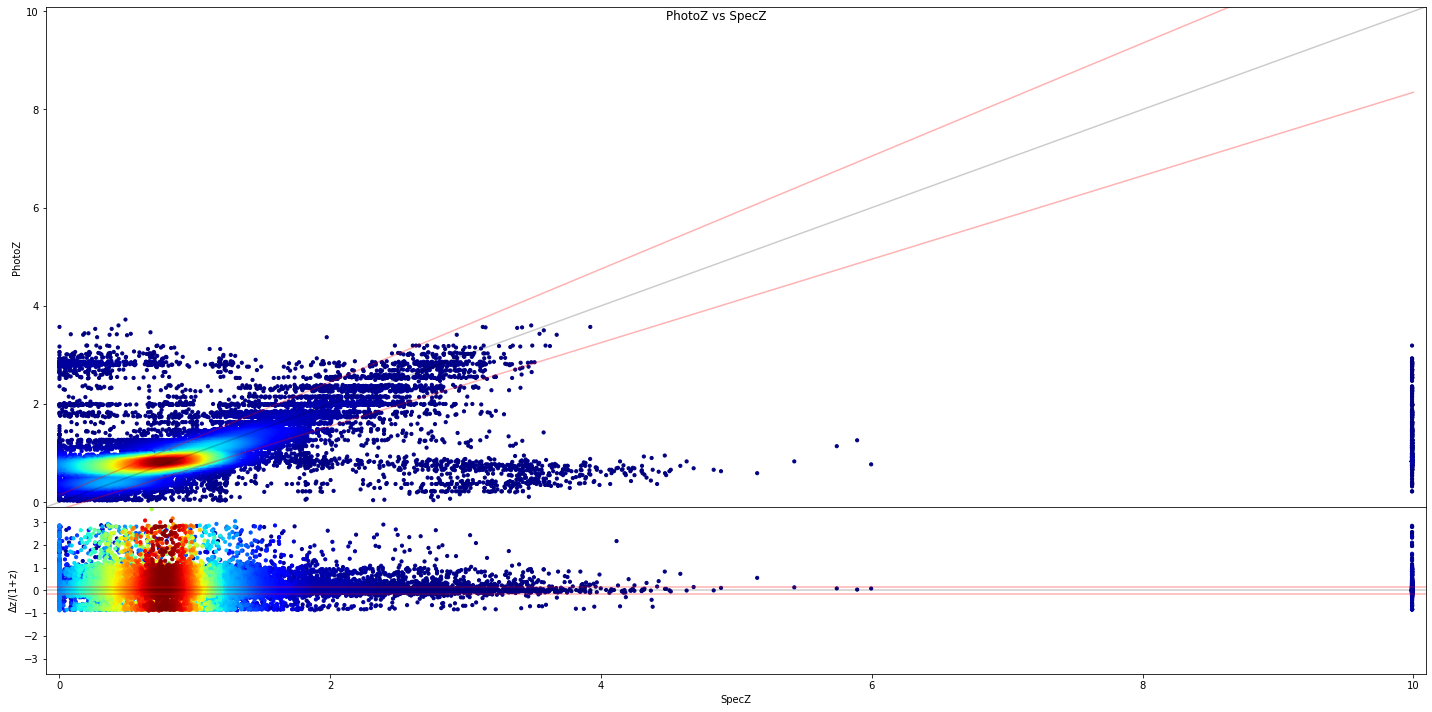

In [18]:
pvs = SpeczPhotozPlot(phz_cut_catalog['ID'], phz_cut_catalog[z_column], phz_cut_catalog[phz_column], data)
pvs.fig.suptitle('PhotoZ vs SpecZ')

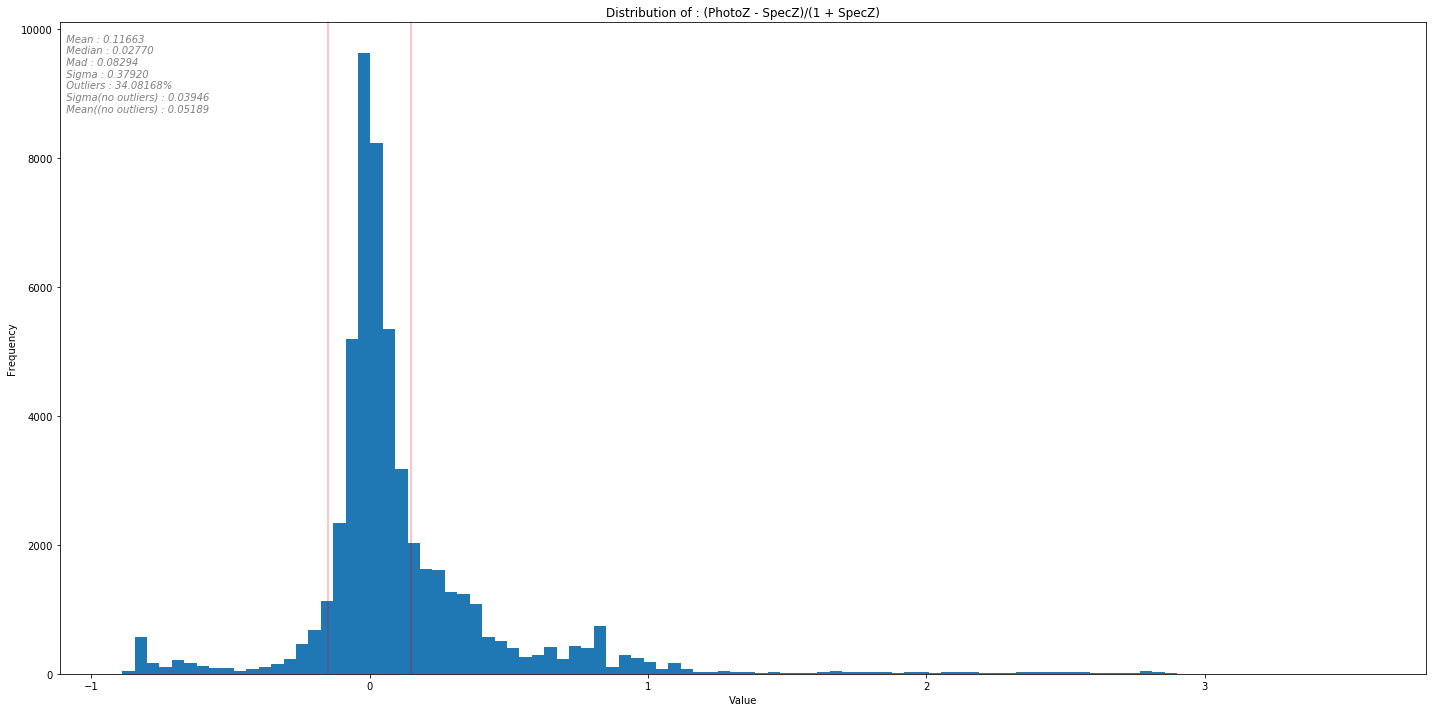

In [19]:
_ = displayHistogram(data, mean, median, mad, sigma, outliersPercent, sigmaNoOutliers, meanNoOutliers)

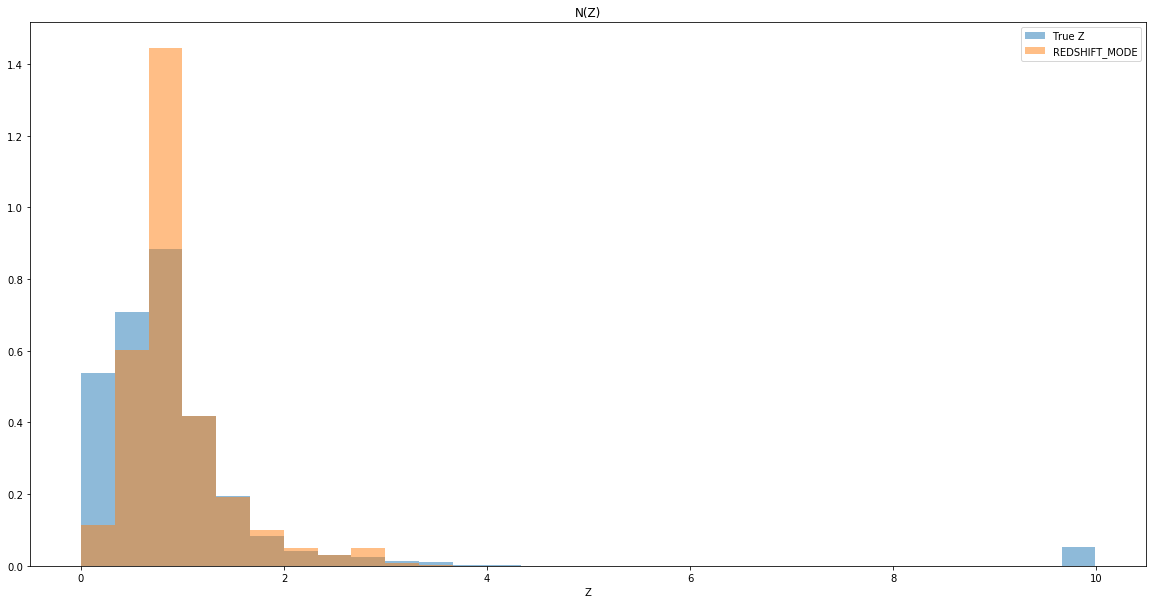

In [20]:
plt.figure()
plt.title('N(Z)')
bins = plt.hist(phz_cut_catalog[z_column], bins=30, alpha=0.5, density=True, label='True Z')
plt.hist(phz_cut_catalog[phz_column], bins=bins[1], alpha=0.5, density=True, label=phz_column)
plt.xlabel('Z')
plt.legend()
plt.show()

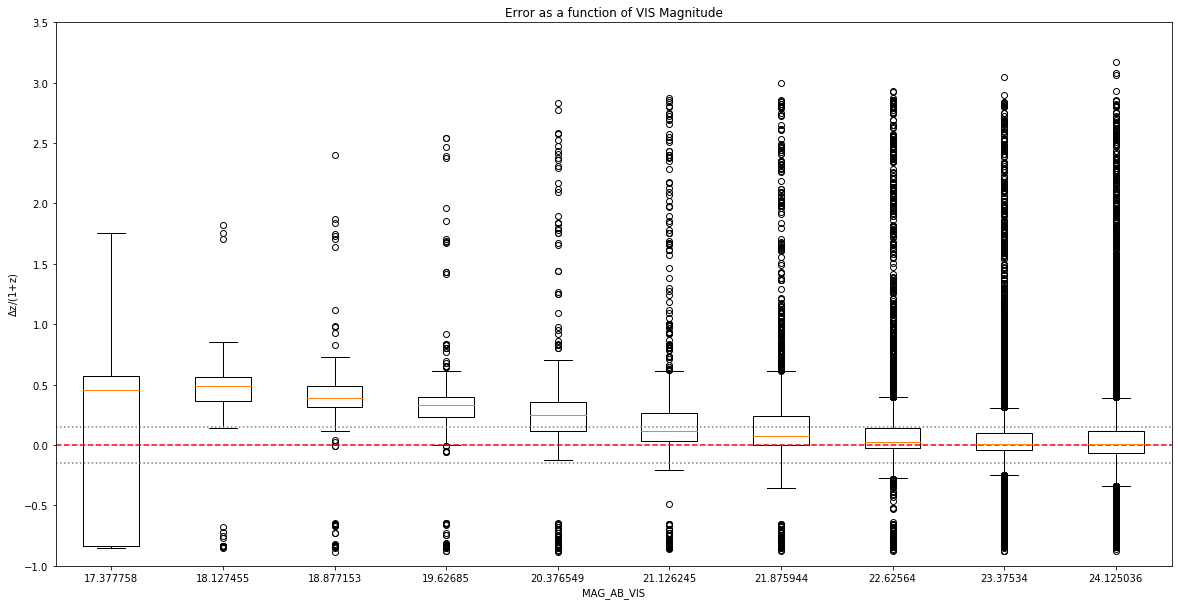

In [21]:
_ = boxPlot(phz_cut_catalog['MAG_AB_VIS'], data)
plt.title('Error as a function of VIS Magnitude')
plt.ylim(-1, 3.5)
plt.show()

# PHZ flagged sources

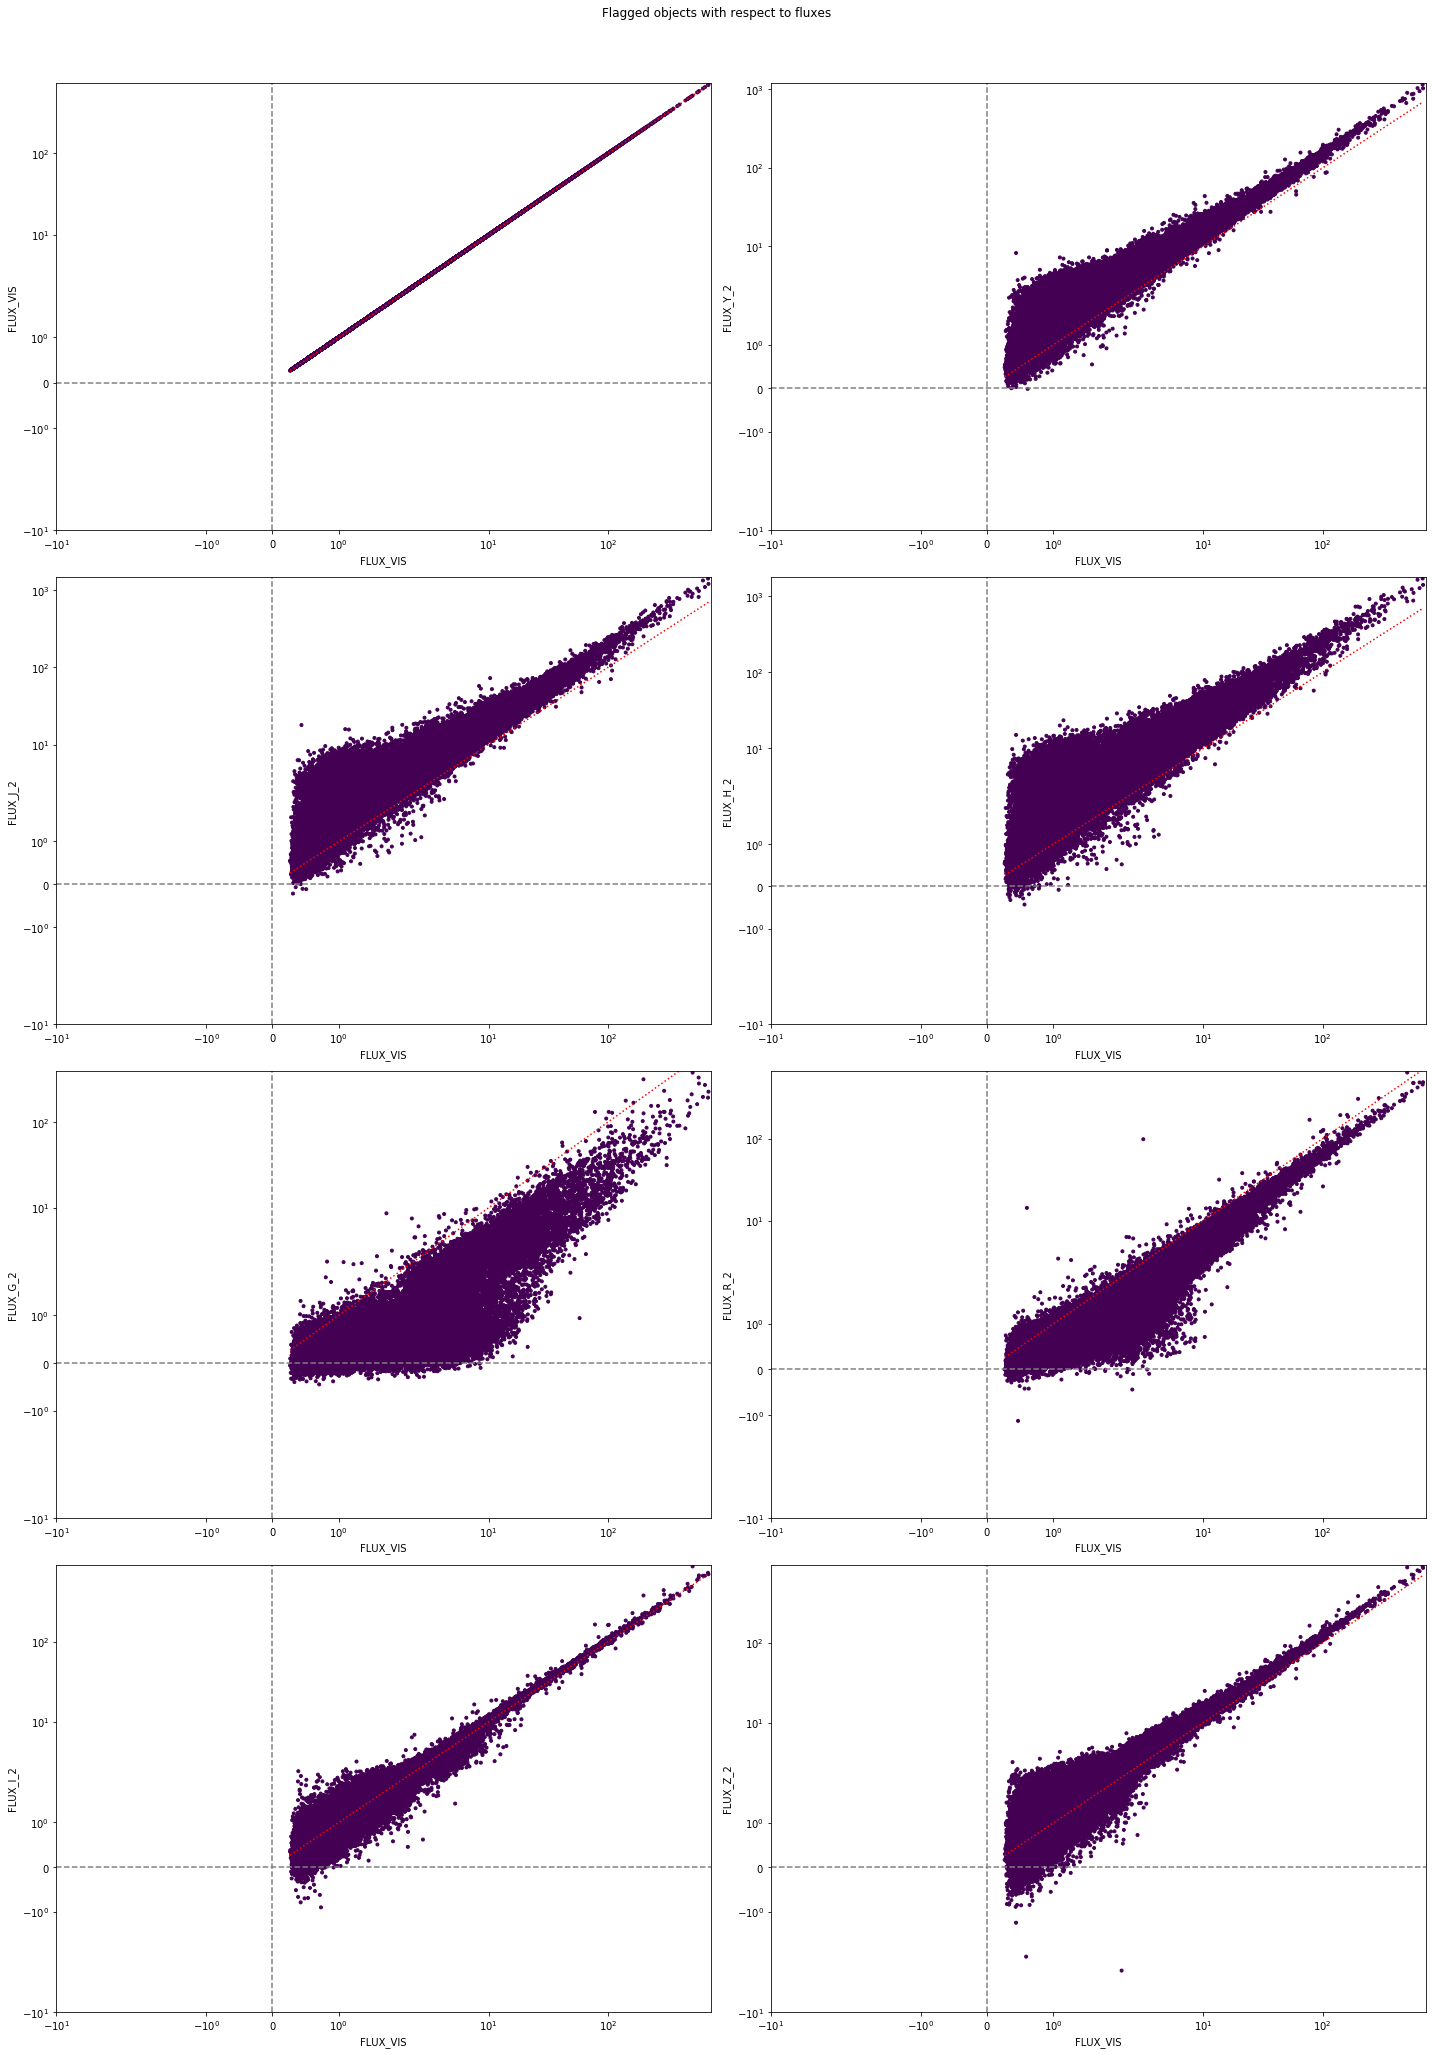

In [22]:
n_filters = len(nnpz_config['target_catalog_filters'])
ncols = 2
nrows = n_filters // ncols + (n_filters % ncols > 0)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20, 30))
axes = axes.ravel()

vis_min = np.min(phz_catalog['FLUX_VIS'])
vis_max = np.max(phz_catalog['FLUX_VIS'])

for i, (flux, error, _) in enumerate(nnpz_config['target_catalog_filters']):
    axes[i].scatter(phz_catalog['FLUX_VIS'], phz_catalog[flux], marker='.', c=phz_catalog['AlternativeWeightFlag'], rasterized=True)
    #axes[i].set_title(f'{flux}')
    axes[i].set_xlabel('FLUX_VIS')
    axes[i].set_ylabel(flux)
    axes[i].set_xlim(-10)
    axes[i].set_ylim(-10)
    axes[i].plot([vis_min, vis_max], [vis_min, vis_max], c='red', linestyle=':')
    axes[i].axvline(0, 0, 1, c='gray', linestyle='--')
    axes[i].axhline(0, 0, 1, c='gray', linestyle='--')
    axes[i].set_xscale('symlog')
    axes[i].set_yscale('symlog')

plt.suptitle('Flagged objects with respect to fluxes')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

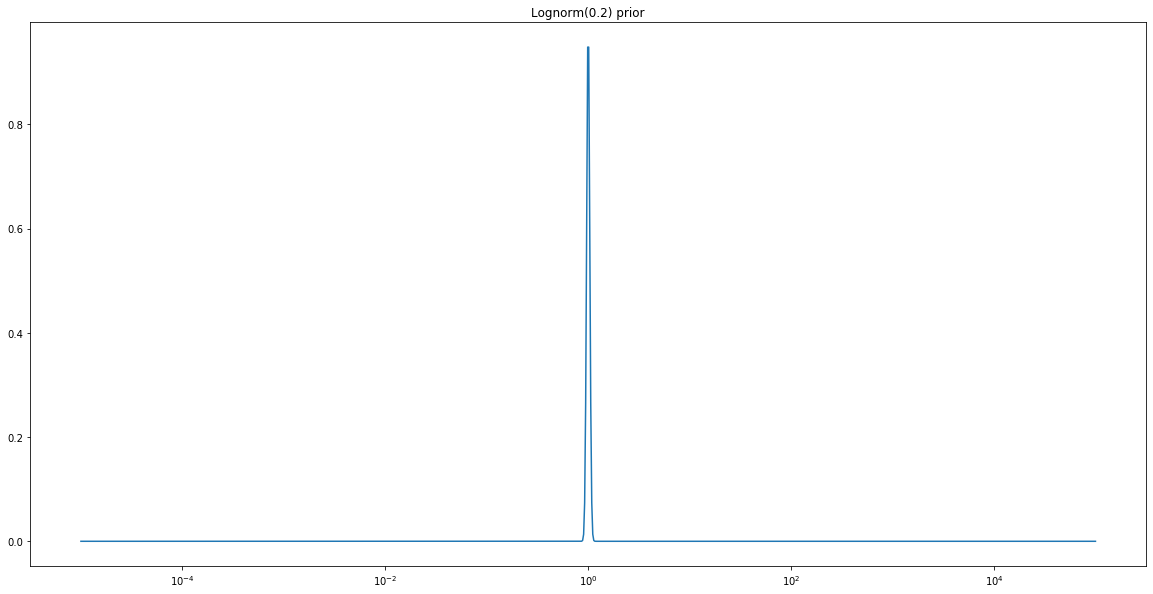

In [23]:
prior = lambda x: np.exp(-np.log(x)**2/0.05**2)
prior_a = np.exp(np.linspace(np.log(1e-5), np.log(1e5), 1000))
plt.figure()
plt.plot(prior_a, prior(prior_a))
plt.xscale('log')
plt.title('Lognorm(0.2) prior')
plt.show()

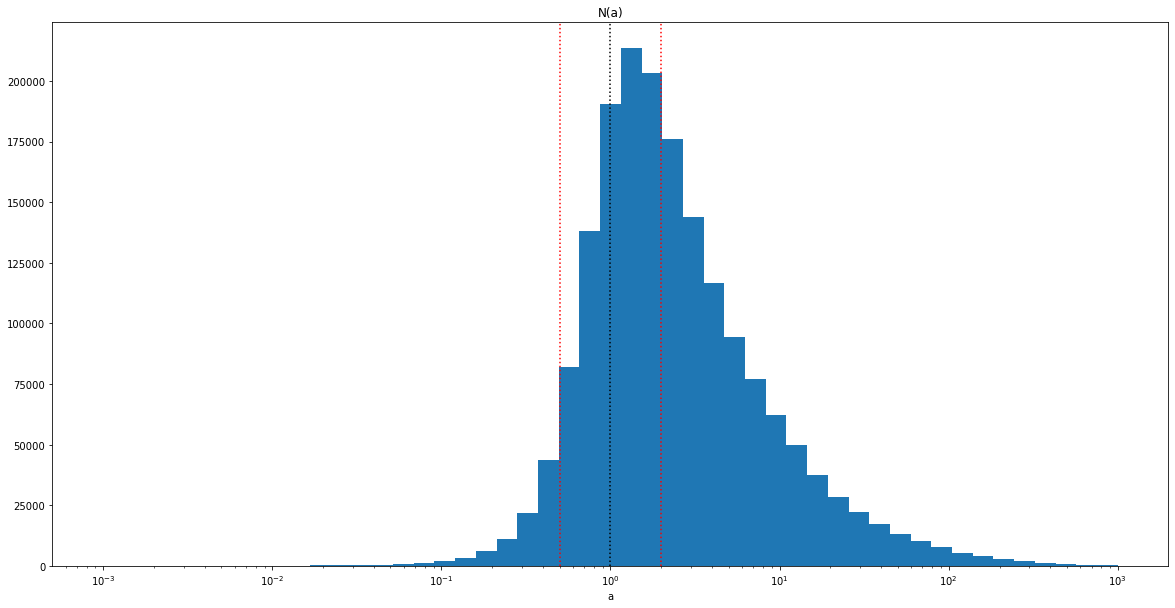

In [24]:
plt.figure()
plt.hist(phz_catalog['NEIGHBOR_SCALING'].ravel(), bins=10**np.linspace(-3., 3.))
plt.xscale('log')
plt.axvline(1, 0, 1, c='black', linestyle=':')
plt.axvline(2, 0, 1, c='red', linestyle=':')
plt.axvline(0.5, 0, 1, c='red', linestyle=':')
plt.xlabel('a')
plt.title('N(a)')
plt.show()

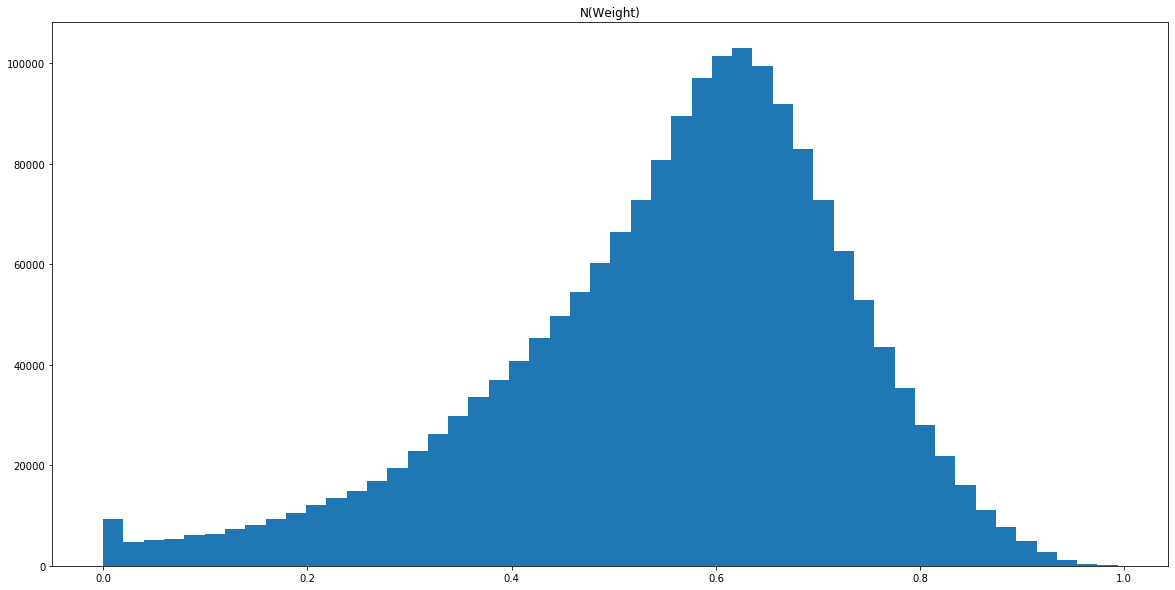

In [25]:
plt.figure()
plt.title('N(Weight)')
plt.hist(phz_catalog['NEIGHBOR_WEIGHTS'][phz_catalog['AlternativeWeightFlag']==0].ravel(), bins=50)
plt.show()

In [26]:
phz_catalog['AlternativeWeightFlag'].sum()

0

## Random selection of PDZ

In [27]:
# Selection done with chi2, makeing sure we have some objects with flagged weights
obj_idx = [ 7343, 22866, 32306, 34438, 20946,  6924,  7407, 31967,  2557, 28324]

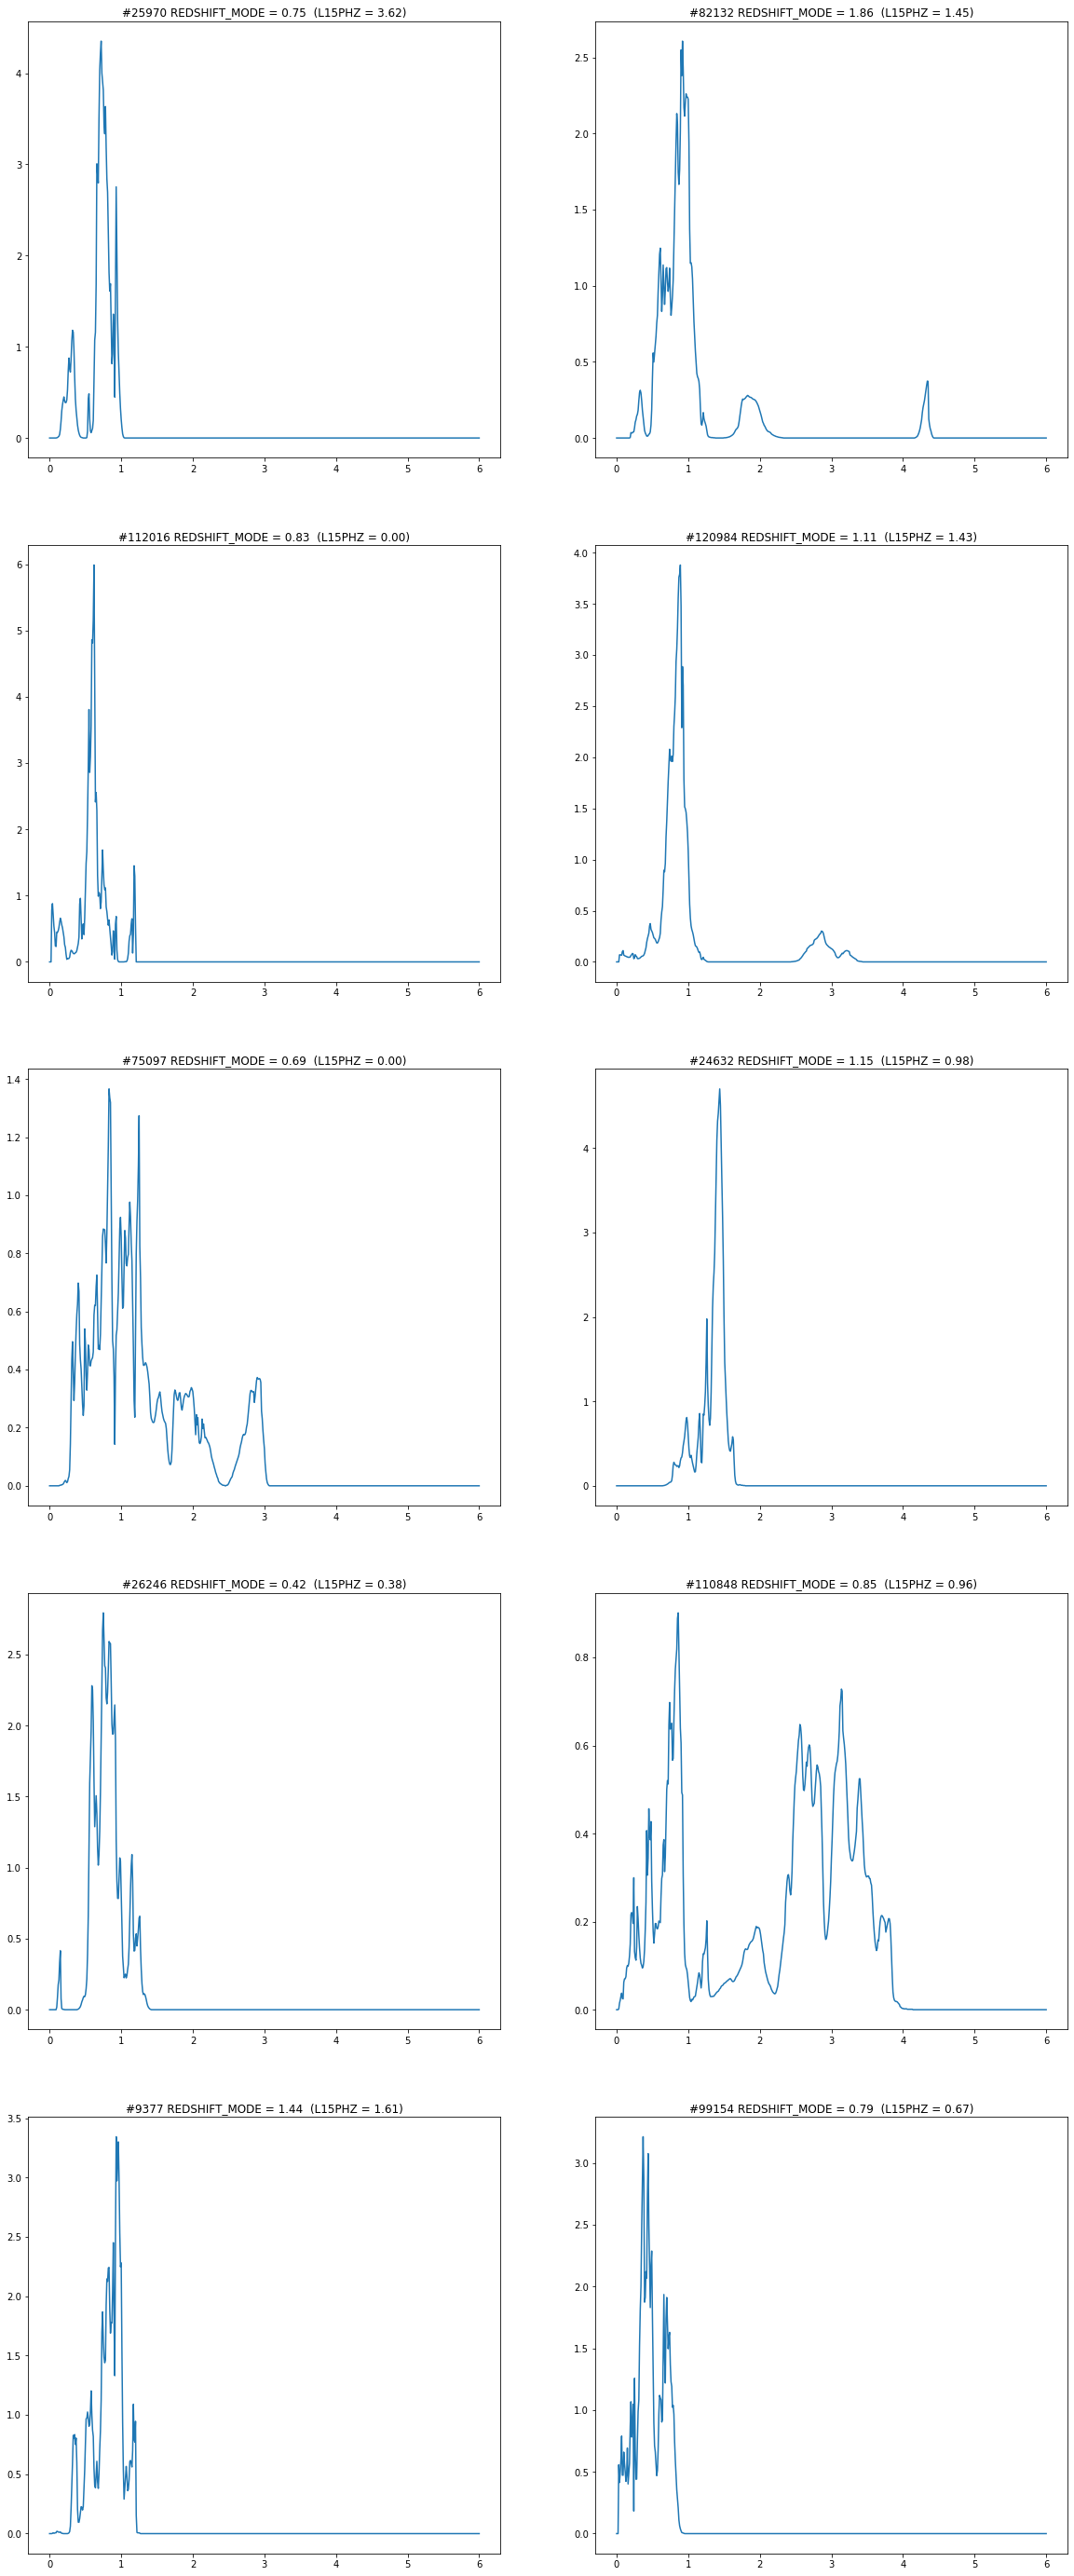

In [28]:
ncols = 2
nrows = 5

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10*nrows))
axes = axes.ravel()

for i, ax in enumerate(axes):
    obj = phz_cut_catalog[obj_idx[i]]
    ax.plot(pdz_bins['BINS_PDF'], phz_cut_catalog['REDSHIFT_PDF'][i])
    flagged = 'flagged' if obj['AlternativeWeightFlag'] else ''
    ax.set_title(f'#{obj["ID"]} {phz_column} = {obj[phz_column]:.2f} {flagged} ({z_column} = {obj[z_column]:.2f})')